In [ ]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2, estimate_derivative
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime
import sklearn
import pickle
from scipy.ndimage import gaussian_filter1d
from tools import load, split, pseudoderivative, estimate_derivative, plot_two_intervals, get_samples
from collections import defaultdict

In [16]:
from matplotlib.colors import ListedColormap
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "font.family": "Helvetica",
})

palette = ['#405cca', '#c23232', '#269f30', '#1d1d1d']
cmap = ListedColormap(palette, name='custom')



In [ ]:
filename = '1_600_20'
rng = np.random.default_rng(42)  # for reproducibility

sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

In [ ]:
grid_k = np.arange(10,25,5)
grid_p = np.arange(0.1,1.1,0.1)
grid_n_fold = 5
n_samples = np.arange(1, 11)

In [ ]:
# --- Load ---
with open('data/gridsearch_rapid_inference_short.pkl', 'rb') as f:
    data = pickle.load(f)

ks_raw        = np.asarray(data['params']['k'])
ps_raw        = np.asarray(data['params']['p'])
nsamples_raw  = np.asarray(data['params']['n_sample'])
test_acc_raw  = np.asarray(data['results']['test_acc'])

# --- Group by (n_sample, k, p) and average over folds ---
acc_lists = defaultdict(list)
for k, p, ns, acc in zip(ks_raw, ps_raw, nsamples_raw, test_acc_raw):
    acc_lists[(int(ns), int(k), float(p))].append(float(acc))

mean_acc = {key: float(np.mean(vals)) for key, vals in acc_lists.items()}

# Unique sorted axes
ks = sorted(set(int(x) for x in ks_raw))
ps = sorted(set(float(x) for x in ps_raw))
n_samples = sorted(set(int(x) for x in nsamples_raw))

# Build matrices per n_sample (rows = p, cols = k)  << SWAPPED HERE
mats = {}
for ns in n_samples:
    mat = np.full((len(ps), len(ks)), np.nan, dtype=float)
    for j, p in enumerate(ps):
        for i, k in enumerate(ks):
            if (ns, k, p) in mean_acc:
                mat[j, i] = mean_acc[(ns, k, p)]
    mats[ns] = mat

# Consistent color scale across all plots
vals = [m[~np.isnan(m)].ravel() for m in mats.values() if np.any(~np.isnan(m))]
all_vals = np.concatenate(vals) if vals else np.array([0.0, 1.0])
vmin, vmax = float(np.min(all_vals)), float(np.max(all_vals))
if not np.isfinite(vmin): vmin = 0.0
if not np.isfinite(vmax): vmax = 1.0
if vmin == vmax:
    vmin, vmax = vmin - 1e-6, vmax + 1e-6

# --- Plot: 2 rows x 5 columns ---
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 6), constrained_layout=True)
axes = np.array(axes).reshape(rows, cols)

# Hide all; show only those we use
for ax in axes.ravel():
    ax.set_visible(False)

norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap()

last_im = None
for idx, ns in enumerate(n_samples):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    ax.set_visible(True)
    mat = mats[ns]

    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="auto", origin="lower")
    last_im = im

    ax.set_title(f"$n_{{samples}} = {ns}$")
    ax.set_xticks(range(len(ks)))
    ax.set_xticklabels([str(k) for k in ks], rotation=0, ha="center")
    ax.set_yticks(range(len(ps)))
    ax.set_yticklabels([f"{p:.1f}" for p in ps])
    ax.set_xlabel("k")
    ax.set_ylabel("p")

    # Annotate each cell
    for j in range(mat.shape[0]):       # over p (rows)
        for i in range(mat.shape[1]):   # over k (cols)
            val = mat[j, i]
            if np.isnan(val):
                continue
            r_, g_, b_, _ = cmap(norm(val))
            luminance = 0.2126 * r_ + 0.7152 * g_ + 0.0722 * b_
            txt_color = 'black' if luminance > 0.5 else 'white'
            ax.text(i, j, f"{val:.3f}", ha="center", va="center", fontsize=8, color=txt_color)

# Shared colorbar
if last_im is not None:
    cbar = fig.colorbar(last_im, ax=[ax for ax in axes.ravel() if ax.get_visible()], shrink=0.9)
    cbar.set_label("Mean Test Accuracy")

plt.show()


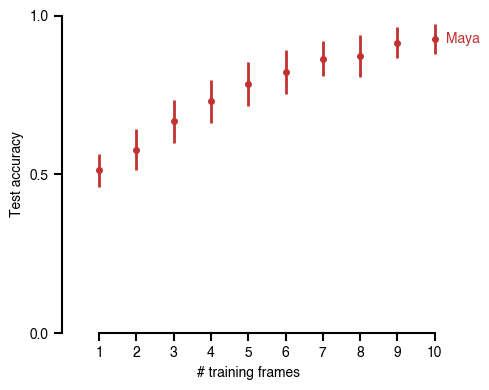

In [17]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
with open('data/gridsearch_rapid_inference_short.pkl', 'rb') as f:
    data = pickle.load(f)

ns_raw  = np.asarray(data['params']['n_sample'])
acc_raw = np.asarray(data['results']['test_acc'], dtype=float)

# --- Aggregate mean/std per #frames ---
x_vals = sorted(set(int(x) for x in ns_raw))
means, stds = [], []
for ns in x_vals:
    vals = acc_raw[ns_raw == ns]
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        means.append(np.nan)
        stds.append(np.nan)
    else:
        means.append(float(np.mean(vals)))
        stds.append(float(np.std(vals, ddof=1)) if vals.size > 1 else 0.0)

x = np.asarray(x_vals, dtype=float)

# Small horizontal offset scale (kept for consistency with your style)
dx = (np.diff(np.unique(x)).min() if x.size > 1 else 1.0) * 0.05

# --- Plot (style copied from your example) ---
plt.figure(figsize=(5, 4))

# Single series (markers only, no lines)
plt.errorbar(
    x, means, yerr=stds,
    linestyle='', linewidth=2, alpha=1.,
    fmt='o', markersize=4,
    capsize=0, clip_on=False,
    color=palette[1]
)

# Axis labels
plt.xlabel("# training frames")
plt.ylabel("Test accuracy")

# Axis limits + ticks
plt.xlim(0, x.max() if x.size else 1.0)
plt.ylim(0, 1)
plt.xticks(x, labels=[str(int(v)) for v in x])
plt.yticks([0, 0.5, 1])

# No grid lines
plt.grid(False)

# Thicker axis lines + ticks; hide top/right
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_bounds(0, 10)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis="both", width=1.5, length=6)

# Bound bottom spine from first to last tick (matches your style)
if x.size:
    ax.spines["bottom"].set_bounds(x[0], x[-1])

# Inline label at the last point
if x.size:
    plt.text(
        x[-1] + 0.3, means[-1],
        "Maya", color=palette[1],
        va="center", ha="left"
    )

plt.tight_layout()
os.makedirs("figs", exist_ok=True)
plt.savefig("figs/acc_vs_frames.png", dpi=600, bbox_inches="tight")
plt.savefig("figs/acc_vs_frames.pdf", dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
import pickle
import numpy as np
from collections import defaultdict

from sklearn import svm, metrics
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

# from your_module import load, get_samples

# ---------------------------
# 1) Best (k, p) per n_sample
# ---------------------------
with open('data/gridsearch_rapid_inference_short.pkl', 'rb') as f:
    data = pickle.load(f)

ks_raw       = np.asarray(data['params']['k'])
ps_raw       = np.asarray(data['params']['p'])
nsamples_raw = np.asarray(data['params']['n_sample'])
test_acc_raw = np.asarray(data['results']['test_acc'])

acc_lists = defaultdict(list)
for k, p, ns, acc in zip(ks_raw, ps_raw, nsamples_raw, test_acc_raw):
    acc_lists[(int(ns), int(k), float(p))].append(float(acc))

mean_acc = {key: float(np.mean(vals)) for key, vals in acc_lists.items()}
n_samples = sorted(set(int(x) for x in nsamples_raw))
ks = sorted(set(int(x) for x in ks_raw))
ps = sorted(set(float(x) for x in ps_raw))

best_cfg = {}
for ns in n_samples:
    best_key, best_val = None, -np.inf
    for k in ks:
        for p in ps:
            key = (ns, k, p)
            if key in mean_acc and mean_acc[key] > best_val:
                best_key, best_val = (k, p), mean_acc[key]
    best_cfg[ns] = None if best_key is None else {
        "k": best_key[0], "p": best_key[1], "mean_test_acc": best_val
    }

print("Best (k, p) per n_sample from gridsearch (mean over folds):")
for ns in n_samples:
    bc = best_cfg[ns]
    if bc is None:
        print(f"  n_sample={ns}: no config found")
    else:
        print(f"  n_sample={ns}: k={bc['k']}, p={bc['p']:.1f}, mean_acc={bc['mean_test_acc']:.4f}")

# ---------------------------
# 2) Load raw dataset handles
# ---------------------------
train_data, train_seq, train_times, train_seq_times = load('1_600_20', reduced=True)

# ------------------------------------------------------------
# 3) Train/tune per n_frames so dims always match at inference
# ------------------------------------------------------------
results = {ns: {} for ns in n_samples}

for ns in n_samples:
    # Build train/test views with exactly ns frames (already flattened to 2-D)
    X_train, Y_train, X_test, Y_test = get_samples(
        train_data, train_seq, train_times, train_seq_times,
        idx_split=450, n_frames=ns
    )
    n_train = len(Y_train)
    # Guard for tiny datasets
    n_splits = max(2, min(3, n_train))
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- Linear ---
    clf_lin = svm.SVC(kernel="linear")
    clf_lin.fit(X_train, Y_train)
    y_lin = clf_lin.predict(X_test)
    results[ns]["linear"] = {
        "acc": metrics.accuracy_score(Y_test, y_lin)
    }

    # --- RBF (tuned) ---
    param_dist_rbf = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__gamma": loguniform(1e-3, 1e1),
    }
    search_rbf = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="rbf")),
        param_distributions=param_dist_rbf,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_rbf.fit(X_train, Y_train)
    y_rbf = search_rbf.best_estimator_.predict(X_test)
    results[ns]["rbf"] = {
        "acc": metrics.accuracy_score(Y_test, y_rbf),
        "best_params": search_rbf.best_params_
    }

    # --- Polynomial (tuned) ---
    param_dist_poly = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__degree": [2, 3, 4],
        "svc__gamma": loguniform(1e-3, 1e1),
    }
    search_poly = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="poly")),
        param_distributions=param_dist_poly,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_poly.fit(X_train, Y_train)
    y_poly = search_poly.best_estimator_.predict(X_test)
    results[ns]["poly"] = {
        "acc": metrics.accuracy_score(Y_test, y_poly),
        "best_params": search_poly.best_params_
    }

    # --- Sigmoid (tuned) ---
    param_dist_sig = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__gamma": loguniform(1e-3, 1e1),
    }
    search_sig = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="sigmoid")),
        param_distributions=param_dist_sig,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_sig.fit(X_train, Y_train)
    y_sig = search_sig.best_estimator_.predict(X_test)
    results[ns]["sigmoid"] = {
        "acc": metrics.accuracy_score(Y_test, y_sig),
        "best_params": search_sig.best_params_
    }

# -----------------------
# 4) Compact text summary
# -----------------------
print("\n=== Accuracy per n_sample (train+test built with n_frames=ns) ===")
for ns in n_samples:
    bc = best_cfg[ns]
    if bc is None:
        print(f"\n[n_sample={ns}] best (k,p): —")
    else:
        print(f"\n[n_sample={ns}] best (k,p) from grid: k={bc['k']}, p={bc['p']:.1f} (mean_acc={bc['mean_test_acc']:.4f})")
    row = results[ns]
    for kernel in ["linear", "rbf", "poly", "sigmoid"]:
        info = row[kern]()
